<div style="background-color: #C0C78C; padding: 10px; border-radius: 5px;">
  <h1>Telecom Customer Churn Prediction - Data Training</h1>
    <ul>
        <li>In this project, we are exploring a churn prediction dataset from a telecom company.</li>
        <li>The goal is to identify patterns and trends in customer behavior that can help predict churn, which refers to the customers leaving the    service.</li>
        <li>By performing exploratory data analysis (EDA), we aim to uncover insights into factors that influence customer retention, examine the relationships between various features, and detect any data anomalies.</li>
        <li>The findings from this analysis will inform the development of a predictive model to help the telecom company proactively address customer churn.</li>
    </ul>
   
</div>

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h2>Import Libraries</h2>
</div>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score


<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h2>Read Files</h2>
</div>

In [3]:
data_path = 'Data/preprocessed_dataset.csv'

In [4]:
df = pd.read_csv(data_path)

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h2>Dataset Overview</h2>
</div>

In [7]:
print(f"Columns:\n {df.columns}")

Columns:
 Index(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Avg Monthly GB Download', 'Paperless Billing',
       'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Customer Status', 'clv',
       'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E',
       'Offer_no_offer', 'Internet Type_DSL', 'Internet Type_Fiber Optic',
       'Internet Type_no_internet', 'Online Security_Yes',
       'Online Security_no_internet', 'Online Backup_Yes',
       'Online Backup_no_internet', 'Device Protection Plan_Yes',
       'Device Protection Plan_no_internet', 'Premium Tech Support_Yes',
       'Premium Tech Support_no_internet', 'Streaming TV_Yes',
       'Streaming TV_no_internet', 'Streaming Movies_Yes',
       'Streaming Movies_no_internet', 'Streaming Music_Yes',
  

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <ul>
      <li>Identify target feature and remove from dataset.</li>
</div>

In [8]:
X = df.drop(['Customer Status'], axis = 1)

In [9]:
y = df.loc[:,'Customer Status'].values

In [10]:
# Train/test split ensuring same proportion of events in both batches
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['Customer Status'])

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h1>Outlier Analysis</h1>

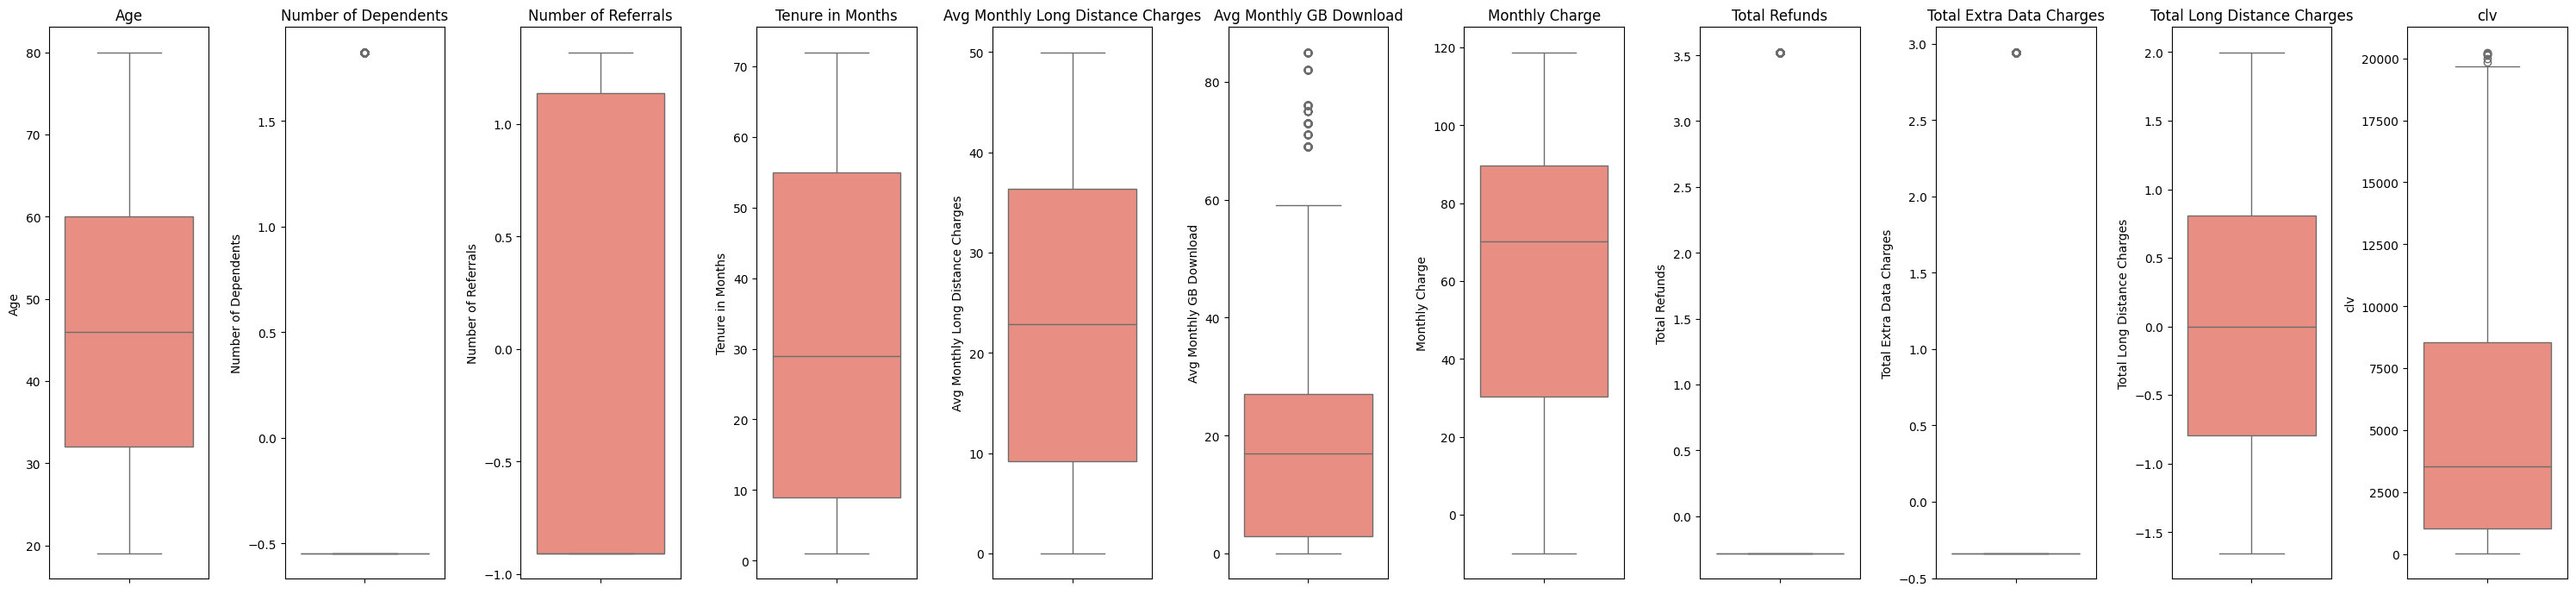

In [25]:
numerical_columns = [col for col in X.select_dtypes(include=['number']).columns if df[col].nunique() > 2]
num_plots = len(numerical_columns)

fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(30, 7))

for index, col in enumerate(numerical_columns):
    sns.boxplot(y=df[col], ax=axes[index],color = 'salmon')
    axes[index].set_ylabel(col)
    axes[index].set_title(col)

plt.tight_layout()
plt.show()

In [12]:
# Function to determine outliers from the IQR
numerical_cols = X.select_dtypes(include=['number']).columns
def find_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return outliers


In [13]:
# Identify columns with outliers
for k, v in df[numerical_cols].items():
        outliers = find_outliers(v)
        perc = len(find_outliers(v)) * 100.0 / np.shape(df[numerical_cols])[0]
        if len(outliers) != 0:
            
            print(f'{k}:  Number of Outliers = {len(outliers)} | Percentage of Outliers = {perc:.2f}%')
            print("\n")

Number of Dependents:  Number of Outliers = 1627 | Percentage of Outliers = 23.10%


Avg Monthly GB Download:  Number of Outliers = 362 | Percentage of Outliers = 5.14%


Total Refunds:  Number of Outliers = 525 | Percentage of Outliers = 7.45%


Total Extra Data Charges:  Number of Outliers = 728 | Percentage of Outliers = 10.34%


clv:  Number of Outliers = 7 | Percentage of Outliers = 0.10%




<div style="background-color: #C0C78C; padding: 10px; border-radius: 5px;">
  <h1>Handle outliers</h1>
  <ul>
      <li>To those columns where outliers where found a limit on those columns in the upper and lower bound were implemented.</li>
  </ul>

In [14]:
def handle_outliers(X_train, X_test, columns):
    for col in columns:
        Q1 = np.percentile(X_train[col], 25)
        Q3 = np.percentile(X_train[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers in X_train
        X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)

        # Replace outliers in X_test using X_train bounds
        X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)

    return X_train, X_test

In [15]:
columns_with_outliers = ['Number of Dependents', 'Phone Service', 'Internet Service', 'Avg Monthly GB Download', 
                         'Total Refunds','Total Extra Data Charges']

X_train, X_test = handle_outliers(X_train, X_test, columns_with_outliers)

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h1>Scaling of features</h1>

In [16]:
# Standard Scaling. Transform X_train and X_test
scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h1>Handling Imbalance</h1>

In [17]:
# Use of SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
print('Resampled training set shape:\n', pd.Series(y_resampled).value_counts())

Resampled training set shape:
 2    3776
0    3776
1    3776
Name: count, dtype: int64


<div style="background-color: #C0C78C; padding: 10px; border-radius: 5px;">
  <h1>Model Training with a Random Forest</h1>

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
target_names = {0: 'Churned', 1: 'Joined', 2: 'Stayed'}
# Calculate metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report, including precision, recall, and F1-score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred,target_names=[target_names[i] for i in sorted(target_names)]))

Precision: 0.8238911679295392
Recall: 0.8218594748048261
F1-Score: 0.8228120994550121
Classification Report:
              precision    recall  f1-score   support

     Churned       0.66      0.68      0.67       374
      Joined       0.70      0.70      0.70        91
      Stayed       0.90      0.89      0.90       944

    accuracy                           0.82      1409
   macro avg       0.75      0.76      0.75      1409
weighted avg       0.82      0.82      0.82      1409



<div style="background-color: #C0C78C; padding: 10px; border-radius: 5px;">
  <h1>Analysis of results</h1>
  <ul>
      <li><b>Overall Metrics:</b></li>
          The model has an overall precision of 0.84, which means that 84% of the instances labeled as positive by the model were correct. The recall is 0.837, indicating that the model correctly identified 83.7% of the actual positive cases. The F1-score is 0.839, a balanced measure of precision and recall. These metrics show that the model performs well overall.
  </ul>
  <ul>
      <li><b>Class Specific Performance:</b>
          <ul>
              <li>Churned:
                  <ul>
                      <li>Precision: 0.69, meaning that 69% of the time when the model predicts a customer will churn, it's correct.</li>
                      <li>Recall: 0.72, so 72% of actual churned customers were correctly identified by the model.</li>
                      <li>F1-Score: 0.70, a balanced metric between precision and recall.</li>
                  </ul>
              </li>
              <li>Joined:
                  <ul>
                      <li>Precision: 0.71, meaning 71% of the time when the model predicts a customer has joined, it's correct.</li>
                      <li>Recall: 0.71, so 71% of customers who actually joined were correctly identified.</li>
                      <li>F1-Score: 0.71, indicating good balance between precision and recall.</li>
                  </ul>
              </li>
              <li>Stayed:
                  <ul>
                      <li>Precision: 0.91, meaning that when the model predicts a customer has stayed, it's correct 91% of the time.</li>
                      <li>Recall: 0.90, so the model identified 90% of the actual stayed customers correctly.</li>
                      <li>F1-Score: 0.91, showing high performance for this class.</li>
                  </ul>
              </li>
          </ul>
      </li>
  </ul>
  <ul>
      <li><b>Imbalanced Classes</b>:</li>
      The model performs significantly better for the Stayed class, which has the most support (944 samples), likely because it has more training data. The Churned and Joined classes have fewer instances (374 and 91, respectively), leading to slightly lower performance. The macro avg and weighted avg provide a better overall picture:
      <ul>
          <li>Macro avg averages the performance metrics across all classes without taking class imbalance into account, giving an F1-score of 0.77.</li>
          <li>Weighted avg adjusts for class imbalance, resulting in an F1-score of 0.84, showing that the model performs better overall by correctly handling the dominant classes.</li>
      </ul>
  </ul>
  <ul>
      <li><b>Accuracy:</b></li>
      The model has an accuracy of 0.84, meaning that 84% of the total predictions were correct. However, because of the class imbalance, accuracy alone is not a sufficient metric. Hence, the precision, recall, and F1-score provide a more complete evaluation of the model’s performance.
  </ul>

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h1>Confusion Matrix</h1>

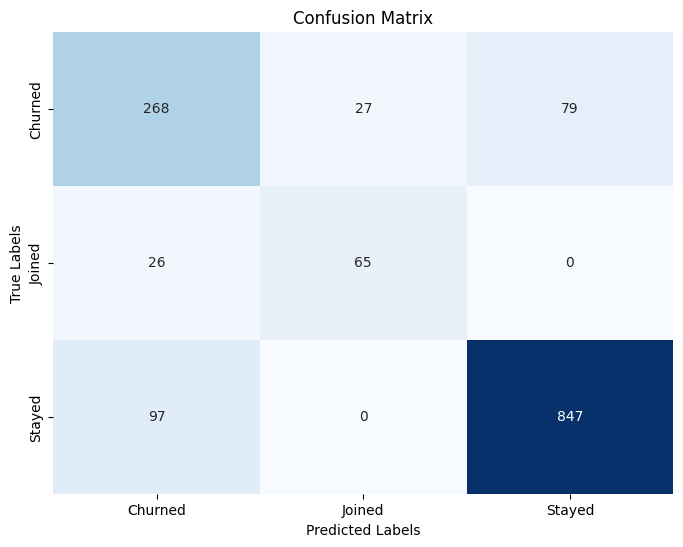

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Churned', 'Joined','Stayed'], yticklabels=['Churned', 'Joined','Stayed'])

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color: #FEFAE0; padding: 10px; border-radius: 5px;">
  <h1>Feature Importance</h1>


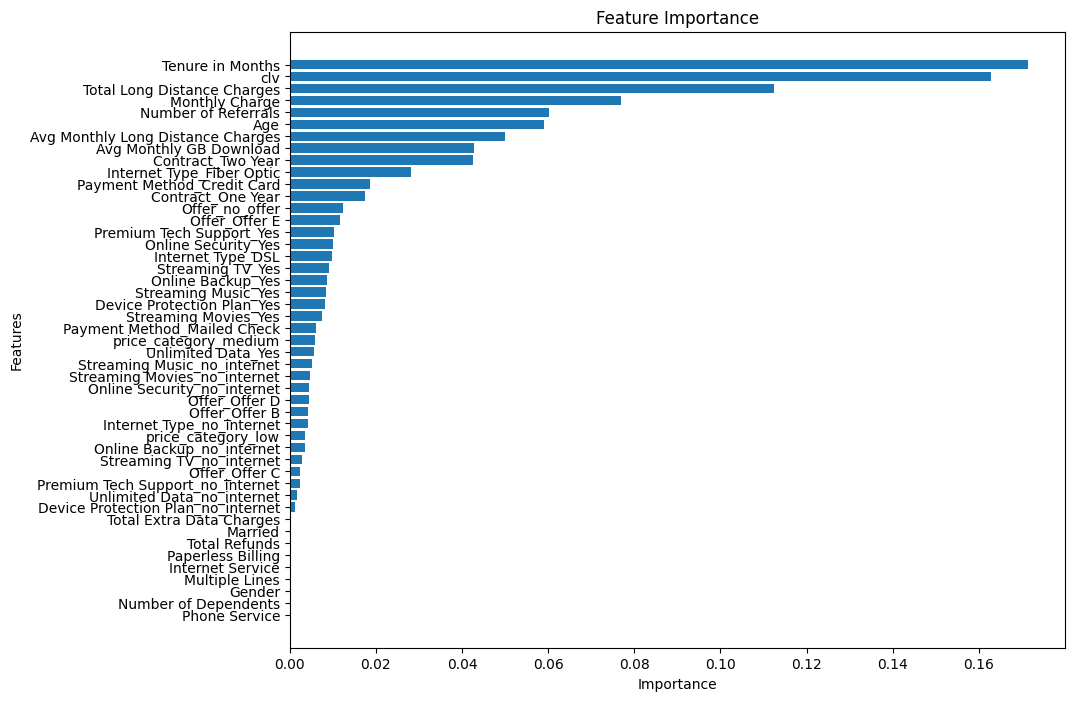

In [23]:
feature_importances =rf_model.feature_importances_

# Create a DataFrame for feature importance
features = X_resampled.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [24]:
# Assuming 'df' is your DataFrame and 'Churn' is the binary target variable
correlations = df.corr()

# Check correlation of important features with churn
print(correlations['Customer Status'][['Tenure in Months', 'clv', 'Total Long Distance Charges','Monthly Charge']])

Tenure in Months               0.446411
clv                            0.286030
Total Long Distance Charges    0.313240
Monthly Charge                -0.139854
Name: Customer Status, dtype: float64


<div style="background-color: #C0C78C; padding: 10px; border-radius: 5px;">
  <h1>Feature Importance Analysis</h1>
  <ul>
      <li>After having observed the four more important features for the prediction, I checked the correlation between the features and the target variable.</li>
      <li>It is evident that <b>Tenure in Months</b>, <b>clv</b> and <b>Total Long Distance Charges</b> have a positive correlation to the customers that stayed. Meaning that the more these features increase also the customer stays.</li>
      <li>On the other hand <b>Monthly Charge</b> has a negative correlation meaning the more they are being charged, the less they stay.</li>
  </ul>
  

<div style="background-color: #C0C78C; padding: 10px; border-radius: 5px;">
  <h1>Model Improvement</h1>
  <ul>
      <li>To further improve the churn prediction project, focusing on model optimization through hyperparameter tuning could enhance performance. Implementing a grid search or random search would allow the selection of the best combination of parameters for the Random Forest model, ensuring higher accuracy and better generalization to unseen data.</li>
      <li>Additionally, exploring advanced ensemble techniques like stacking or boosting could improve prediction power.</li>
      <li>Moreover, trying different data augmentation tools to handle the imbalance can be tested.</li>
      <li>Finally, monitoring model drift and updating the model periodically would ensure that predictions remain accurate as customer behavior evolves over time.</li>
      
  </ul>